# Lab 2 - Used Cars Classification Models
#### By: David Wei, Sophia Wu, Dhruba Dey, Queena Wang

## -------------------- Introduction --------------------
In this exercise, we will be building on top of our Used_Car_Dataset we had analyized prior. The main goal we aim to address will be in modeling two of our nominal value attributes: 'Body_Type' and 'Has_Accidents'. We will use varying classification methods and techniques to evaluate if there are any significant  differences in the models and ultimately decide on which model is best to use as a classifier. 

**Table of Contents**
1. [Introduction](#---------------------Introduction---------------------)
2. [Data Preparation - Part 1](#---------------------Data-Preparation---Part-1---------------------)
3. [Data Preparation - Part 2](#---------------------Data-Preparation---Part-2---------------------)
4. [Modeling and Evaluation 1](#---------------------Modeling-and-Evaluation-1---------------------)
5. [Modeling and Evaluation 2](#---------------------Modeling-and-Evaluation-2---------------------)
6. [Modeling and Evaluation 3](#---------------------Modeling-and-Evaluation-3---------------------)
7. [Modeling and Evaluation 4](#---------------------Modeling-and-Evaluation-4---------------------)
8. [Modeling and Evaluation 5 - Adv/Disadv](#---------------------Modeling-and-Evaluation-5---------------------)
9. [Modeling and Evaluation 6 - Feature Importance](#-----------------Modeling-and-Evaluation-6---------------------)
10. [Deployment & Conclusions](#---------------------Deployment&Conclusions-----------------)
 

In [2]:
##### importing libraries and reading in file #####
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') #ignoring warnings
import missingno as msno

##### viz libraries #####
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine.data import economics
from plotnine import ggplot, aes, geom_line

##### general sklearn libraries #####
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
import ptitprince as pt
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler #for scaling
from sklearn.model_selection import StratifiedKFold

##### preprocessing libraries #####
# !pip install imblearn
# !pip install delayed
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import NearMiss

##### model libraries #####
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree

##### model Evaluation #####
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

For convenience and clarity, we have exported all of the data tidying and cleaning we have applied to our original dataset from our initial EDA workbook as an importable file. This will allow us to simply pick up on where we left off without cluttering our notebook with all prior code. For reference, please refer to the following [github link](https://github.com/chee154/ml-Py-used_cars/blob/main/Used_Car_Lab_1_DataVisualization.ipynb) where all work has been contained.

In [2]:
%%time
#df_raw = pd.read_csv('data/finaldata.csv')
#df_raw = pd.read_csv('C:/ml-Py-used_cars/data/kaggle_used_cars_data.csv')
df_raw = pd.read_csv('Data/used_cars_data_cleaned.csv')
print('# of Records: '+str(len(df_raw)))
print('# of Columns: '+str(df_raw.shape[1]))

# of Records: 697989
# of Columns: 18
CPU times: user 699 ms, sys: 149 ms, total: 848 ms
Wall time: 862 ms


## -------------------- Data Preparation - Part 1 --------------------
[Back to Top](#---------------------Introduction---------------------)

### Addressing Empty Values
<b>NOTE</b>: First time running the logistic regression model returned an error: 
<br>
*ValueError: Input contains NaN, infinity or a value too large for dtype('float64').*
<br>
Therefore, we will fix this by once again removing any strangling NA records from our dataset.

In [3]:
df_cleaned = df_raw.copy()
df_cleaned = df_cleaned.dropna()
print(len(df_cleaned))
print('# of Records Removed: '+str(len(df_raw)-len(df_cleaned)))

697881
# of Records Removed: 108


### Cleaning up final dataframe
After the initial EDA, we will make the appropriate adjustments to our dataset based on our findings. To begin, let's get look at the relationship between **'length'** and **'height'** due to it's high correlation.

In [4]:
df_test = df_cleaned.copy()
print(df_test.shape[1])

if df_test['length'].equals(df_test['height']) == True:
    print('they are the same... dropping one')
    df_test = df_test.drop(columns='height')
    print('remaining columns:',df_test.shape[1])
else: 
    print('they are not the same')

18
they are the same... dropping one
remaining columns: 17


## Transformations for Modeling

### IntegerEncoding
Once the data has been imported and cleaned, we will work on transforming our dataset to be more useful for our classification models. To start we will first integerencode all of our categorical (object) datatypes as numbers.

In [5]:
def number_encode_features(df):
    result = df_cleaned.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object or result.dtypes[column]==np.bool:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    print('Columns converted: '+str(encoders))
    return result

Now we are ready for some model building!

In [6]:
encoded_data = number_encode_features(df_cleaned)
df_final = encoded_data.copy()
print('# of Records: '+str(len(df_final)))
print('# of Columns: '+str(df_final.shape[1]))

Columns converted: {'body_type': LabelEncoder(), 'frame_damaged': LabelEncoder(), 'has_accidents': LabelEncoder(), 'is_new': LabelEncoder()}
# of Records: 697881
# of Columns: 18


## Feature Selection & Dimensionality Reduction

### Running PCA for feature select

In [7]:
#creating the data containing numberical dataset
df_num = df_final[['city_fuel_economy','daysonmarket','engine_displacement', 'highway_fuel_economy','horsepower',
                  'length', 'maximum_seating','mileage','owner_count','price','seller_rating','width','year']]

In [8]:
names = np.array(['city_fuel_economy','daysonmarket','engine_displacement', 'highway_fuel_economy','horsepower', 
		'length', 'maximum_seating','mileage','owner_count','price','seller_rating','width','year'])
features_names = pd.Series(names)

In [174]:
from sklearn.decomposition import PCA
# Standardize the feature
df_num= StandardScaler().fit_transform(df_num)

pca = PCA(n_components=6)
df_num_pca = pca.fit(df_num).transform(df_num) # fit data and then transform it

# print the components
print ('pca:', pca.components_.transpose())

pca: [[-0.42132195  0.10484459 -0.07575576  0.0349237  -0.03502952  0.10394236]
 [ 0.00816961  0.03943551  0.15608508  0.75987378  0.62174468 -0.08615542]
 [ 0.38779046 -0.05961322  0.13399639 -0.13894031  0.06548041 -0.3597012 ]
 [-0.42033337  0.07322847 -0.00547019  0.01545757 -0.01530633  0.13395932]
 [ 0.39796295  0.06143529  0.28372849 -0.13368919  0.06310181 -0.00394776]
 [ 0.34893888  0.01828504 -0.3868652   0.11651535 -0.07347132 -0.02218401]
 [ 0.25013437 -0.0014054  -0.58073668  0.21767071 -0.10117483 -0.06927466]
 [ 0.0327452  -0.56342485 -0.08415367  0.03716664 -0.0411177  -0.03164666]
 [ 0.01446323 -0.46640452  0.23161095 -0.04082692  0.10577622  0.42763984]
 [ 0.22155206  0.32639307  0.41670299 -0.13676347  0.0571755   0.06396686]
 [ 0.035765   -0.00095536  0.35810053  0.53601347 -0.75518429 -0.07311398]
 [ 0.3177215   0.07822123 -0.08443861  0.11803659 -0.03713884  0.79029352]
 [-0.00816067  0.57165816 -0.12148744  0.00203441 -0.01540709  0.10610315]]


In [175]:
# the explained variance indicates how much information (variance) can be attributed to each of the principal components
pca.explained_variance_ratio_
Sum = sum(pca.explained_variance_ratio_) 
print(pca.explained_variance_ratio_)
print(Sum*100) ## first 6 components explains 84.3% of the variation 

[0.36999273 0.18842452 0.08495619 0.07847443 0.07452814 0.04641989]
84.27959007026324


In [176]:
pca = PCA(n_components=3)
df_num_pca = pca.fit(df_num).transform(df_num) # fit data and then transform it

# print the components
print ('pca:', pca.components_.transpose())

pca: [[-0.42132195  0.10484459 -0.07575576]
 [ 0.00816961  0.03943551  0.15608508]
 [ 0.38779046 -0.05961322  0.13399639]
 [-0.42033337  0.07322847 -0.00547019]
 [ 0.39796295  0.06143529  0.28372849]
 [ 0.34893888  0.01828504 -0.3868652 ]
 [ 0.25013437 -0.0014054  -0.58073668]
 [ 0.0327452  -0.56342485 -0.08415367]
 [ 0.01446323 -0.46640452  0.23161095]
 [ 0.22155206  0.32639307  0.41670299]
 [ 0.035765   -0.00095536  0.35810053]
 [ 0.3177215   0.07822123 -0.08443861]
 [-0.00816067  0.57165816 -0.12148744]]


In [177]:
# the explained variance indicates how much information (variance) can be attributed to each of the principal components
pca.explained_variance_ratio_
Sum = sum(pca.explained_variance_ratio_) 
print(pca.explained_variance_ratio_)
print(Sum*100) ## first 3 components explains 64.3% of the variation 

[0.36999273 0.18842452 0.08495619]
64.33734354838786


In [178]:
# find the weights of the features in the 6 two components

def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array

# assign weights with features
pca_weight_strings = get_feature_names_from_weights(pca.components_, features_names)
pca_weight_strings

['-0.42*city_fuel_ec +0.01*daysonm +0.39*engine_displac -0.42*highway_fuel_ec +0.40*horse +0.35*l +0.25*maximum_se +0.03*mi +0.01*owner_ +0.22* +0.04*seller_r +0.32* -0.01* ',
 '0.10*city_fuel_ec +0.04*daysonm -0.06*engine_displac +0.07*highway_fuel_ec +0.06*horse +0.02*l -0.00*maximum_se -0.56*mi -0.47*owner_ +0.33* -0.00*seller_r +0.08* +0.57* ',
 '-0.08*city_fuel_ec +0.16*daysonm +0.13*engine_displac -0.01*highway_fuel_ec +0.28*horse -0.39*l -0.58*maximum_se -0.08*mi +0.23*owner_ +0.42* +0.36*seller_r -0.08* -0.12* ']

The top 7 Principal Component explains 84% variation of the data, whereas the top 3 does 65%. Though we have built our models using the full dataset including categorical variables, we would like to see which numerical dimensions have contributed much to the top 3 PCs and use those numerical dimensions to build the model and evaluate the different matrix such accuracy, recall and so forth. In this analysis, we use 0.3 as the cut-off coefficient of linear combinations of PC1, PC2 and PC3 to demarcate the significance of the features in these Principal Components. We have found that 'has_accidents','city_fuel_economy','engine_displacement', 'highway_fuel_economy','horsepower','length','mileage','owner_count','price','width','year' contribute meaningfully in top 3 PCs. 

After running dimensionality reduction by using PCA (after standardization) we will utilize the following coefficients:
1. city_fuel_economy
2. engine_displacement
3. highway_fuel_economy
4. horsepower
5. length
6. mileage
7. owner_count
8. price
9. width
10. year
11. body_type

In [179]:
df_pca= df_final[['body_type','has_accidents','city_fuel_economy','engine_displacement', 'highway_fuel_economy','horsepower','length','mileage','owner_count','price','width','year']].copy()

## Preprocessing

### Normalizing Attributes
We next will be normalizing our data attributes by scaling our explanatory variables so that no attribute holds a larger weight when building out our model otherwise it would be dominated by unevenly distributed scaling factors.  

To begin we will clone our final dataset for both of our classifcation tasks for more usability and replicability and then normalize the explanatory values of each dataset task.

In [9]:
%%time

df_body = df_pca.copy()
df_accident = df_pca.copy()

if 'body_type' in df_body:
    y_body = df_body['body_type'].values
    del df_body['body_type'] 
    X_body = df_body.values
       
if 'has_accidents' in df_accident:
    y_accident = df_accident['has_accidents'].values
    del df_accident['has_accidents'] 
    X_accident = df_accident.values
    
scl = StandardScaler()
X_body = scl.fit_transform(X_body)
yhat_body = np.zeros(y_body.shape) 

X_accident = scl.fit_transform(X_accident)
yhat_accident = np.zeros(y_accident.shape) 

Wall time: 452 ms


### Undersampling
Before running any models, we wanted to quickly review our earlier analysis on our classification response variable "body_type". A quick plot below shows that the majority of our used car body type's are either "Sedans" and "SUV/Crossovers". This results in imbalanced classes which will overfit our models since the 2 dominant body type's will simply outweight the other car body types. 

As a result, we will apply Random Under-Sampling to balance the distribution of our response classses by trimming down the instances of the majority classes. We chose undersampling as opposed to oversampling simply because we had a good amount of data to work with (~700k instances) and did not find a need to synthetically create minority class instances.

#### Response Class Distribution before Undersampling

Text(0.5, 0.98, "'body_type' Distribution")

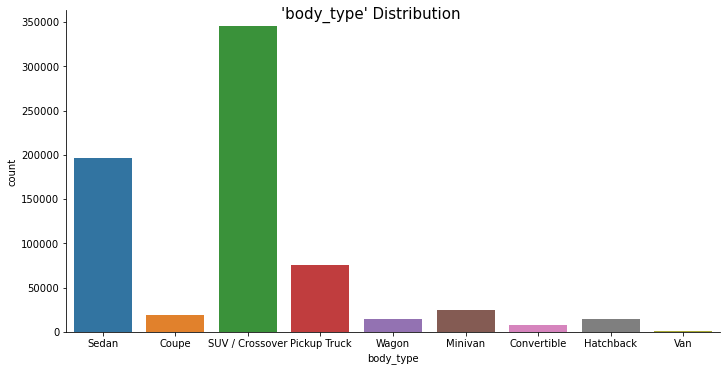

In [34]:
body_type_plot = sns.catplot(x="body_type", kind="count",data=df_cleaned,height=5, aspect=2,legend=False)
body_type_plot.fig.suptitle("'body_type' Distribution",
                  fontsize=15, fontdict={"weight": "bold"})

Text(0.5, 0.98, "'has_accidents' Distribution")

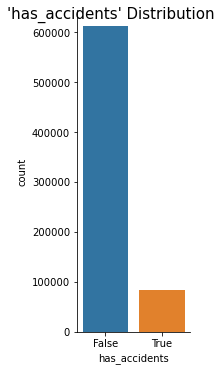

In [35]:
accident_plot = sns.catplot(x="has_accidents", kind="count",data=df_cleaned,height=5, aspect=.5)
accident_plot.fig.suptitle("'has_accidents' Distribution",
                  fontsize=15, fontdict={"weight": "bold"})

#### Undersampling 'body_type' using NearMiss-3
We initially used Random Undersamplying but found that the results of that undersampling technique, though effective resulted in non-uniformity measures across all classes. We found that though 'Sedan' and 'SUV/Crossover' was somewhat balanced, a new class of 'Convertible's dominated the classes measures.
http://glemaitre.github.io/imbalanced-learn/generated/imblearn.under_sampling.RandomUnderSampler.html

Thus we tried another undersampling technique known as NearMiss. This method, based on distances between majority and minority classes, "*selects the closest examples from the majority class for each minority class.*". Which resulted in much better, more congruent results that we were expecting.

- Undersampling Methods: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
- NearMiss Method: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.under_sampling.NearMiss.html

#### Undersampling via NearMiss v-3

In [10]:
%%time
# !pip install imblearn
# !pip install delayed
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

# define oversampling strategy
# undersample = RandomUnderSampler(sampling_strategy='majority')
undersample = NearMiss(version=3, n_neighbors_ver3=3)

# fit and apply the transform
X_body_undersample, y_body_undersample= undersample.fit_resample(X_body, y_body)
X_accident_undersample, y_accident_undersample = undersample.fit_resample(X_accident, y_accident)

Wall time: 4min 49s


#### Undersampling 'Body_Type'

Text(0.5, 0.98, "Undersampling 'body_type' using NearMiss-3")

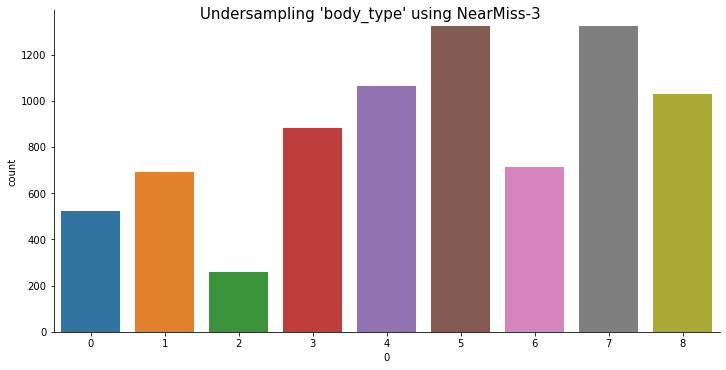

In [10]:
#convert numpy array to dataframe to plot via sns
y_body_plot = pd.DataFrame(y_body_undersample)

body_undersample_plot = sns.catplot(x=0, kind="count",data=y_body_plot,height=5, aspect=2,legend=False)
body_undersample_plot.fig.suptitle("Undersampling 'body_type' using NearMiss-3",
                  fontsize=15, fontdict={"weight": "bold"})

#### Undersampling 'has_accidents'

Text(0.5, 0.98, "Undersampling 'has_accidents' using NearMiss-3")

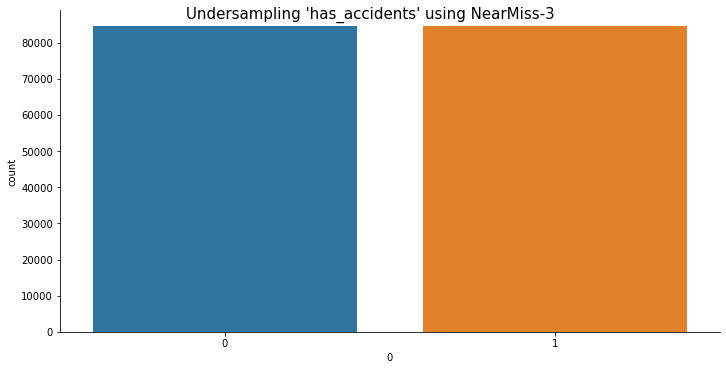

In [11]:
#convert numpy array to dataframe to plot via sns
y_accident_plot = pd.DataFrame(y_accident_undersample)

body_undersample_plot = sns.catplot(x=0, kind="count",data=y_accident_plot,height=5, aspect=2,legend=False)
body_undersample_plot.fig.suptitle("Undersampling 'has_accidents' using NearMiss-3",
                  fontsize=15, fontdict={"weight": "bold"})

## -------------------- Data Preparation - Part 2 --------------------
[Back to Top](#---------------------Introduction---------------------)

#### Task 1 ['Body_Type'] - Final Datset:
Our first response variable will be for **'Body_Type'** which contains the following values {SUV / Crossover, Sedan, Pickup Truck, Minivan, Coupe, Hatchbach, Wagon, Convertible, Van}. We began by cleaning up our dataset by removing any empty values and IntegerEncoding our nominal attributes. Feature Select was then performed using PCA and resulted in a reduced set of variables. Once PCA was done, we then split that dataframe into 2 separate dataframes, one for our first classification task and the other for our second classification task. This was done to avoid variable conflicts in our modeling section. 


#### Task 2 ['Has_Accidents'] - Final Datset:
Our second resposne variable will be **'Has_Accidents'**, which in it's rawest form a boolean value ('T', 'F') that tells us whether a car has been in an accident or not. As mentioend earlier, we IntegerEncoded the original attribue values that contained {Yes, No} into a integer based boolean value. Another dataframe containing only 'Has_Accidents' as our resposne variable was created in conjunection with a separate 'Body_Type' resposne variable so that we could model out our predicted (Yhat) attributes accordingly.  

#### Visualization Dataset Naming Schemes
In the figure below, we have visualized the split for our 2 tasks that we created for our classification/regression tasks. It takes our Df_PCA defined dataframe that contains all the Data Tidying and then splits it based on the task. Training/Testing was then performed on each split so that we could build our models without it interferring with our model variable names. One thing to note is that our Yhat variable remained the same until our Modeling process in which the fitted classifier was then created per each model we used. 

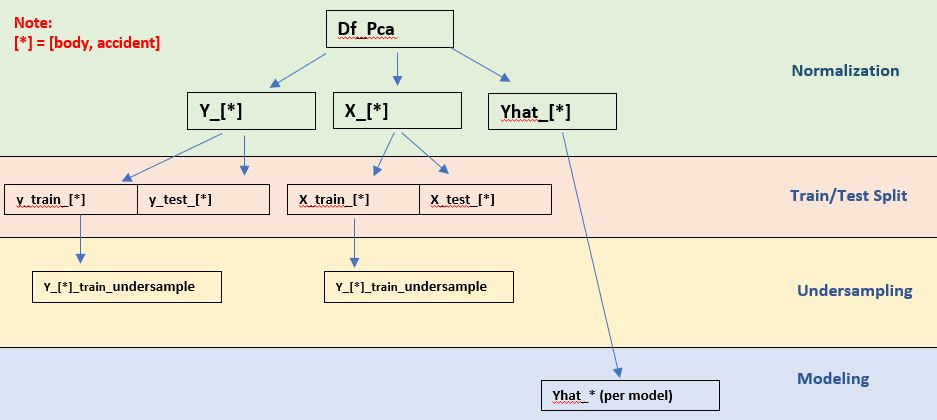

## -------------------- Modeling and Evaluation 1 --------------------
[Back to Top](#---------------------Introduction---------------------)

Accuracy treats every class as equally important, but in case of unbalance data as ours, it is not suitable for analyzing the model results just using accuracy. “Has_accident” data is highly imbalanced as it represents 88% true vs 12% false, and if we erroneously predict a used car with an accident as a false, the buyer will be misguided and pay much higher price than the used car actually deserves. On the other hand, if our model predicts a used car with no accident as a false, the buyer will bid lower for the car and eventually miss the opportunity to buy a used car he or she would like to. However, in this situation, the precision of predicting theaccident car accurately would protect our clients more than the no-accident car inaccurately. That is the reason, we have explored other metrics of accuracy such as precision, recall and F-measure. 

Precision determines the fraction of records that actually turns out to be positive in the group that the classifier has noted as a positive class [Precision(p) = TP/(TP+FP)]. The higher the precision is, the lower the number of false positive errors occurred, the result which we seek in our “Has_accident” model. 

Recall measures the fraction of positive examples correctly predicted by the classifier [Recall(r) = (TP/TP+FN)]. Classifiers with large recall have very few positive observations misclassified as the negative class. In other way, the value of recall is equivalent to the true positive rate, which is also well sought after a would-be characteristic of our model as we do not want to deny our clients from seizing the opportunity to buy a car with no accident. In a nutshell, we would like to have a model which not only has high accuracy, but also demonstrates high precision and recall, though we emphasize a bit more on precision in case of “Has_accident” model. However, building a model that maximizes both precision and recall is the key challenge. Now, here comes F1-measure, which combines precision and recall into a single matric [F1 = 2rp/(r+p)], which represents a harmonic mean between recall and precision. Let us present it in a different way: F1 = [2/((1/r) +(1/p))]. By looking the formula, we can say that F1 will be higher when both r and p are reasonably high. Inour “Has_accident”, we should be looking for higher F1. “Body_Type” is another model we have built, and the dataset of this model is imbalanced as well. Here, the model will predict the type of vehicle such as SUV, Sedan and so forth, the information which is important for our clients to bid for a used car purchase. However, unlike “Has_accident” model, this model will treat all predictions equally, therefore accuracy plays an important role along with high recall and precision.

## -------------------- Modeling and Evaluation 2 --------------------
[Back to Top](#---------------------Introduction---------------------)

### Training and Testing Split
We next apply cross validation to our dataset using a StratifiedKFold 10-fold split to our data. By using the StratifiedKFold cross-validation method, this allows us to preserve our class distribution during the train/test split that we worked on balancing during pre-processing. Additionally, by enabling the shuffle paramater=True, this allows our cross validation to shuffle prior to splitting without the overlaping in folds that other CV methods such as the StratifiedShuffleSplit consequently results in. This prevents any potential overfitting due to repeating samples in the folds and results in a pure cross-validation split.

One thing to note in this section is that we did **not** undersample our validation (test set) and that undersampling was only done on our training set. This was done for later replicability and will be further discussed in our 'Deployment' Section. 

#### Splitting into Train/Test Sets

In [11]:
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

for train_body, test_body in cv.split(X_body,y_body):
    # note that these are sparse matrices
    X_train_body = X_body[train_body] 
    X_test_body  = X_body[test_body] 
    y_train_body = y_body[train_body]
    y_test_body  = y_body[test_body]
    
for train_body, test_body in cv.split(X_accident,y_accident):
    # note that these are sparse matrices
    X_train_accident = X_accident[train_body] 
    X_test_accident = X_accident[test_body] 
    y_train_accident = y_accident[train_body]
    y_test_accident = y_accident[test_body]

#### Applying Undersampling to Train splits

In [12]:
%%time
undersample = NearMiss(version=3, n_neighbors_ver3=3)

# fit and apply the transform
X_body_train_undersample, y_body_train_undersample= undersample.fit_resample(X_train_body, y_train_body)
X_accident_train_undersample, y_accident_train_undersample = undersample.fit_resample(X_train_accident, y_train_accident)

Wall time: 3min 43s


#### Reference of all Modeling Variable Sets:
#### 1. For 'Body_Type'

In [13]:
print('Normalized only Train Set (X): '+str(len(X_train_body)))
print('Normalized only Train Set (y): '+str(len(y_train_body)))
print('='*50)
print('Normalized only Test Set (X): '+str(len(X_test_body)))
print('Normalized only Test Set (y): '+str(len(y_test_body)))
print('='*50)
print('Undersampled Train Set (X): '+str(len(X_body_train_undersample)))
print('Undersampled Train Set (y): '+str(len(y_body_train_undersample)))
print('='*50)
print('Normalized (Yhat): '+str(len(yhat_body)))

Normalized only Train Set (X): 628093
Normalized only Train Set (y): 628093
Normalized only Test Set (X): 69788
Normalized only Test Set (y): 69788
Undersampled Train Set (X): 7192
Undersampled Train Set (y): 7192
Normalized (Yhat): 697881


#### 2. For 'Has_Accidents'

In [14]:
print('Normalized only Train Set (X): '+str(len(X_train_accident)))
print('Normalized only Train Set (y): '+str(len(y_train_accident)))
print('='*50)
print('Normalized only Test Set (X): '+str(len(X_test_accident)))
print('Normalized only Test Set (y): '+str(len(y_test_accident)))
print('='*50)
print('Undersampled Train Set (X): '+str(len(X_accident_train_undersample)))
print('Undersampled Train Set (y): '+str(len(y_accident_train_undersample)))
print('='*50)
print('Normalized (Yhat): '+str(len(yhat_accident)))

Normalized only Train Set (X): 628093
Normalized only Train Set (y): 628093
Normalized only Test Set (X): 69788
Normalized only Test Set (y): 69788
Undersampled Train Set (X): 152456
Undersampled Train Set (y): 152456
Normalized (Yhat): 697881


## -------------------- Modeling and Evaluation 3 --------------------
[Back to Top](#---------------------Introduction---------------------)

## Task 1 - 'Body_Type' Classification

### Model [1] and Evaluation - KNN
For our first model, we will be running a kNN classifier model using a baseline parameterization of setting 'n_neighbors' = 3, 'weights'='uniform' and metric using the 'euclidean' distance. 

In [15]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_body_train_undersample,y_body_train_undersample)
yhat_knn = clf_knn.predict(X_test_body)
total_accuracy = accuracy_score(y_test_body, yhat_knn)
#     total_recall = recall_score(y_test_body, yhat, average='weighted')
#     total_precision = precision_score(y_test_body, yhat, average='weighted')
print('kNN (base) Accuracy: %.5f'%(total_accuracy))

kNN (base) Accuracy: 0.33453
Wall time: 4.43 s


#### Re-run KNN model using GridSearch optimization
We next wanted to tune our model using GridSearch that performs an exhaustive serach over our specified parameter values to return the most optimal model parameters in terms of model **accuracy**.

Code Ref: https://medium.datadriveninvestor.com/an-introduction-to-grid-search-ff57adcc0998

In [16]:
%%time
from sklearn.model_selection import GridSearchCV

gsc = GridSearchCV(
        estimator=KNeighborsClassifier(),
        param_grid={
            'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree','kd_tree','brute'],
            'p': [1,2],
            'metric': ['minkowski','euclidean','manhattan']},
        cv=10, scoring='accuracy', verbose=False, n_jobs=-1)

grid_result = gsc.fit(X_body_train_undersample, y_body_train_undersample)
best_params = grid_result.best_params_
best_knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=best_params["n_neighbors"], 
                                weights=best_params["weights"],
                                algorithm=best_params["algorithm"], p=best_params["p"],
                                metric=best_params["metric"])
print('Hypertune Model Recommendation: ',best_knn)
print('='*50)

clf_knn_hyper = best_knn
clf_knn_hyper.fit(X_body_train_undersample,y_body_train_undersample)
yhat_knn_hyper = clf_knn_hyper.predict(X_test_body)
total_accuracy = accuracy_score(y_test_body, yhat_knn_hyper)
#     total_recall = recall_score(y_test_body, yhat, average='weighted')
#     total_precision = precision_score(y_test_body, yhat, average='weighted')
print('kNN (hyperturned) Accuracy: %.5f'%(total_accuracy))

Hypertune Model Recommendation:  KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=1, p=1)
kNN (hyperturned) Accuracy: 0.34560
Wall time: 1min 36s


### Model [2] and Evaluation - ADABoostClassifier
We next ran a AdaBoostClassifier model as the results from our KNN model resulted in extremely low accuracies with a high false positive rate. We inferred that this was due to the class imbalance  that was confirmed when we ran the initial model on artificially adjusted resposne variables. Thus we will next fit a ADABoostClassifier to see if the emphasis on weak learning that can possibly use it's weighted error based algorithm to adjust for our class imbalance.

Inspired by: https://medium.com/@jindeshubham/adaboost-vs-knearest-neighbours-vs-support-vector-classifier-b70c496f23ae

AdaBoost ensemble is an ensemble created from decision trees added sequentially to the model, and it is used to boost the performance of the algorithm, when the weak learn can only slightly predict higher than the usual probability. In each step, the training dataset is weighted, and the initial weight is reset so that the learning can be improved. In that way, the model reaches to the optimal level quickly with a lesser number of depth. However, it generally works well in the binary situation as the model does not require to learn a lot in identifying multiple labels. In our case, we want to try this model to see how it works in multi-label situation and in fact we have used grid search to optimize the hyper parameters. But the performance of the model has not been impressive, and we would discuss further on this.

In [139]:
from sklearn.ensemble import AdaBoostClassifier

clf_adaboost = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_adaboost.fit(X_body_train_undersample, y_body_train_undersample)
yhat_adaboost = clf_adaboost.predict(X_test_body)
total_accuracy = accuracy_score(y_test_body, yhat_adaboost)
print('kNN (hyperturned) Accuracy: %.5f'%(total_accuracy))
#clf.score(X, y)

kNN (hyperturned) Accuracy: 0.22626


#### Re-runAdaBoostClassifier using GridSearch optimization

In [141]:
%%time
#storing parameterized input ranges
n_estimators_list = list(range(1,15))
learning_rate_list = list(np.arange(0.1,1,.1))

#creating GridSearchCV
gsc_adaboost = GridSearchCV(
        estimator=AdaBoostClassifier(),
        param_grid={
            'n_estimators': n_estimators_list,
            'learning_rate': learning_rate_list},
        cv=10, scoring='accuracy', verbose=False, n_jobs=-1)

grid_result_adaboost = gsc_adaboost.fit(X_body_train_undersample, y_body_train_undersample)
best_params_adaboost = grid_result_adaboost.best_params_
best_adaboost = AdaBoostClassifier(random_state=0, 
                                n_estimators=best_params_adaboost["n_estimators"], 
                                learning_rate=best_params_adaboost["learning_rate"])
print('Hypertune Model Recommendation: ',best_adaboost)
print('='*50)

#running model using GridSearch hyperturned model
clf_best_adaboost = best_adaboost
clf_best_adaboost.fit(X_body_train_undersample, y_body_train_undersample)
yhat_best_adaboost = clf_best_adaboost.predict(X_test_body)
total_accuracy = accuracy_score(y_test_body, yhat_best_adaboost)
print('AdaBoostClassifier (hyperturned) Accuracy: %.5f'%(total_accuracy))

Hypertune Model Recommendation:  AdaBoostClassifier(learning_rate=0.9, n_estimators=5, random_state=0)
AdaBoostClassifier (hyperturned) Accuracy: 0.55520
Wall time: 20.7 s


### Model [3] and Evaluation - Naive Bayes Model
We have 10 explanatory variables to classify the body type. And 9 out of 10 are contineous variables and the remaining 1 is a binary variable, which is encoded and normalized. Therefore, the gaussian is appropriate since all variables are contineous.  

In [120]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
gnb_NB = GaussianNB()
yhat_NB = gnb_NB.fit(X_body_train_undersample,y_body_train_undersample).predict(X_test_body)
total_accuracy = accuracy_score(y_test_body, yhat_NB)
total_recall = recall_score(y_test_body, yhat_NB, average='weighted')
total_precision = precision_score(y_test_body, yhat_NB, average='weighted')
print("Number of mislabeled points out of a total %d points : %d"% (X_test_body.shape[0], (y_test_body != yhat_NB).sum()))
print('Accuracy :' ,total_accuracy)
print('Recall :' ,total_recall)
print('Precision :' ,total_precision)

Number of mislabeled points out of a total 69788 points : 53994
Accuracy : 0.22631397948071302
Recall : 0.22631397948071302
Precision : 0.7927804791550073


### Model [4] and Evaluation - Random Forest Classifer with K-means Clustering
First we will try to combine features as much as possible in way that the combined features provide us with a reduced cluster numbers and then we will use the new clusters as labels in our model.  
Next, we will create a dataset based on new clusters and the remaining features which we can not combine. 
Finally, we will use RandomForest classifer for building model. 
Please note we have used the undersampled data as the baseline for this model.

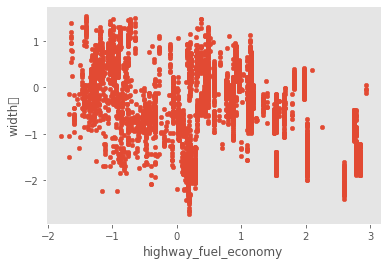

In [149]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

X_body_train_undersample_rndf_df = pd.DataFrame(X_body_train_undersample)
X_test_body_rndf_df = pd.DataFrame(X_test_body)

%matplotlib inline
X1 = X_body_train_undersample_rndf_df[[3,  9]].values
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('highway_fuel_economy'), plt.ylabel('width	')
plt.grid()
plt.show()
## We will take 3 clusters for labels

## Updating test data
Xt1 =X_test_body_rndf_df[[3,  9]].values

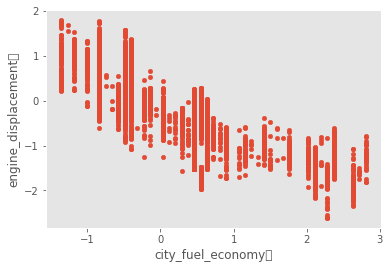

In [150]:
%matplotlib inline
X2 = X_body_train_undersample_rndf_df[[1, 2 ]].values
plt.scatter(X2[:, 1], X2[:, 0]+np.random.random(X2[:, 1].shape)/2, 
             s=20)
plt.xlabel('city_fuel_economy	'), plt.ylabel('engine_displacement	')
plt.grid()
plt.show()
## We will take 6 clusters for labels 
## Updating test data
Xt2 =X_test_body_rndf_df[[1,  2]].values

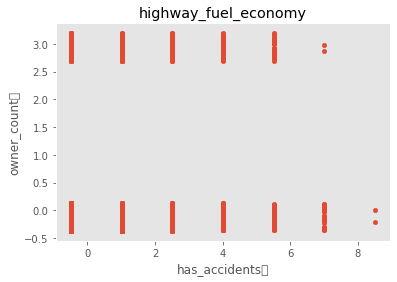

In [151]:
%matplotlib inline
X3 = X_body_train_undersample_rndf_df[[0, 7]].values
plt.scatter(X3[:, 1], X3[:, 0]+np.random.random(X3[:, 1].shape)/2, 
             s=20)
plt.xlabel('has_accidents	'), plt.ylabel('owner_count	')
plt.grid()
plt.title('highway_fuel_economy')
plt.show()
## We will take 10 clusters for labels 
## Updating test data
Xt3 =X_test_body_rndf_df[[0,  7]].values

In [152]:
## Creating the final dataset
from sklearn.cluster import KMeans
cls1 = KMeans(n_clusters=3, init='k-means++',random_state=1)
cls1.fit(X1)
newfeature1 = cls1.labels_ # labels from first kmeans clustering

cls1.fit(Xt1)
newfeaturet1 = cls1.labels_ ## Updating test data

cls2 = KMeans(n_clusters=6, init='k-means++',random_state=1)
cls2.fit(X2)
newfeature2 = cls2.labels_ # labels from second kmeans clustering

cls2.fit(Xt2)
newfeaturet2 = cls2.labels_ ## Updating test data

cls3 = KMeans(n_clusters=10, init='k-means++',random_state=1)
cls3.fit(X3)
newfeature3 = cls3.labels_ # labels from second kmeans clustering

cls3.fit(Xt3)
newfeaturet3 = cls3.labels_ ## Updating test data

## new train data
Xremain = X_body_train_undersample_rndf_df[[4,5,6,8,10]]
X = np.column_stack((Xremain,pd.get_dummies(newfeature1),pd.get_dummies(newfeature2),pd.get_dummies(newfeature3)))

## new test data 
Xtremain = X_test_body_rndf_df[[4,5,6,8,10]]
Xt = np.column_stack((Xtremain,pd.get_dummies(newfeaturet1),pd.get_dummies(newfeaturet2),pd.get_dummies(newfeaturet3)))

In [153]:
## using Random forest classifer to model building
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier(n_estimators=100, random_state=1)
yhat_randf = randf.fit(X,y_body_train_undersample).predict(Xt)
total_accuracy = accuracy_score(y_test_body, yhat_randf)
total_recall = recall_score(y_test_body, yhat_randf, average='weighted')
total_precision = precision_score(y_test_body, yhat_randf, average='weighted')
print("Number of mislabeled points out of a total %d points : %d"% (X_test_body.shape[0], (y_test_body != yhat_randf).sum()))
print('Accuracy :' ,total_accuracy)
print('Recall :' ,total_recall)
print('Precision :' ,total_precision) 

Number of mislabeled points out of a total 69788 points : 41504
Accuracy : 0.405284576144896
Recall : 0.405284576144896
Precision : 0.6782640676596114


### Model [5] and Evaluation - Random Forest Classifer
For random forest, we first classify all the data into categorical variables, and then we ran it using random forest classifier function.

In [59]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_randomforrest = RandomForestClassifier(n_estimators=15, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X_body_train_undersample,y_body_train_undersample):
    clf_randomforrest.fit(X_body_train_undersample,y_body_train_undersample)
    yhat_body_randomforrest = clf_randomforrest.predict(X_test_body)
    
total_accuracy = mt.accuracy_score(y_test_body, yhat_body_randomforrest)
print ('Accuracy', total_accuracy)

Accuracy 0.5024216197627099
Wall time: 1.28 s


[Back: Task 1](#Task-1---'Body_Type'-Classification)

## Task 2 - 'Has_Accidents' Classification

### Model [1] and Evaluation - Random Forest Classifer

In [60]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_randomforest_accident = RandomForestClassifier(n_estimators=15, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X_accident_train_undersample,y_accident_train_undersample):
    clf_randomforest_accident.fit(X_accident_train_undersample,y_accident_train_undersample)
    yhat_accident_randomforest = clf_randomforest_accident.predict(X_test_accident)
    
total_accuracy = mt.accuracy_score(y_test_accident, yhat_accident_randomforest)
print ('Accuracy', total_accuracy)

Accuracy 0.3881326302516192
Wall time: 18.7 s


### Model [2] and Evaluation - Logistic Regression (LR)

In [296]:
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) 

In [297]:
lr_clf.fit(X_accident_train_undersample,y_accident_train_undersample)  # train object
yhat_lr_accident = lr_clf.predict(X_test_accident) # get test set precitions

# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc_lr = mt.accuracy_score(y_test_accident,yhat_lr_accident)
conf_lr = mt.confusion_matrix(y_test_accident,yhat_lr_accident)

print("accuracy", acc_lr )
print("confusion matrix\n",conf_lr)

accuracy 0.28469077778414625
confusion matrix
 [[14404 46914]
 [ 3006  5464]]


### Model [3] and Evaluation - KNN Model

In [306]:
%%time

for K in range(1,11):
    clf_accident_knn = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    clf_accident_knn.fit(X_accident_train_undersample,y_accident_train_undersample)
    yhat_accident_knn = clf_accident_knn.predict(X_test_accident)
    total_accuracy_accident_knn = accuracy_score(y_test_accident, yhat_accident_knn)
    total_recall_accident_knn = recall_score(y_test_accident, yhat_accident_knn, average='weighted')
    total_precision_accident_knn = precision_score(y_test_accident, yhat_accident_knn, average='weighted')
    print('Accuracy of kNN classifier with %d neighbors is: %.5f'%(K,total_accuracy_accident_knn))

Accuracy of kNN classifier with 1 neighbors is: 0.37945
Accuracy of kNN classifier with 2 neighbors is: 0.45620
Accuracy of kNN classifier with 3 neighbors is: 0.40228
Accuracy of kNN classifier with 4 neighbors is: 0.44208
Accuracy of kNN classifier with 5 neighbors is: 0.40394
Accuracy of kNN classifier with 6 neighbors is: 0.43635
Accuracy of kNN classifier with 7 neighbors is: 0.39447
Accuracy of kNN classifier with 8 neighbors is: 0.42305
Accuracy of kNN classifier with 9 neighbors is: 0.39495
Accuracy of kNN classifier with 10 neighbors is: 0.42016
Wall time: 2min 32s


In [167]:
%%time

for K in range(1,11):
    clf_accident_knn2 = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean', algorithm='kd_tree')
    clf_accident_knn2.fit(X_accident_train_undersample,y_accident_train_undersample)
    yhat_accident_knn2 = clf_accident_knn2.predict(X_test_accident)
    total_accuracy_accident_knn2 = accuracy_score(y_test_accident, yhat_accident_knn2)
    total_recall_accident_knn2 = recall_score(y_test_accident, yhat_accident_knn2, average='weighted')
    total_precision_accident_knn2 = precision_score(y_test_accident, yhat_accident_knn2, average='weighted')
    print('Accuracy of kNN classifier with %d neighbors is: %.5f'%(K,total_accuracy_accident_knn2))

Accuracy of kNN classifier with 1 neighbors is: 0.37945
Accuracy of kNN classifier with 2 neighbors is: 0.45620
Accuracy of kNN classifier with 3 neighbors is: 0.40228
Accuracy of kNN classifier with 4 neighbors is: 0.44208
Accuracy of kNN classifier with 5 neighbors is: 0.40394
Accuracy of kNN classifier with 6 neighbors is: 0.43635
Accuracy of kNN classifier with 7 neighbors is: 0.39447
Accuracy of kNN classifier with 8 neighbors is: 0.42305
Accuracy of kNN classifier with 9 neighbors is: 0.39495
Accuracy of kNN classifier with 10 neighbors is: 0.42016
Wall time: 2min 28s


### Model [4] and Evaluation - GaussianNB

In [125]:
gnb_NB_accident_knn = GaussianNB()
yhat_NB_accident_knn = gnb_NB.fit(X_accident_train_undersample,y_accident_train_undersample).predict(X_test_accident)
total_accuracy = accuracy_score(y_test_accident, yhat_NB_accident_knn)
total_recall = recall_score(y_test_accident, yhat_NB_accident_knn, average='weighted')
total_precision = precision_score(y_test_accident, yhat_NB_accident_knn, average='weighted')
print("Number of mislabeled points out of a total %d points : %d"% (X_test_accident.shape[0], (y_test_accident != yhat_NB_accident_knn).sum()))
print('Accuracy :' ,total_accuracy)
print('Recall :' ,total_recall)
print('Precision :' ,total_precision)

Number of mislabeled points out of a total 69788 points : 47241
Accuracy : 0.3230784662119562
Recall : 0.3230784662119562
Precision : 0.7693778982290144


### Model [5] and Evaluation - Random Forest Classifer with K-means Clustering
First we will try to combine features as much as possible in way that the combined features provide us with a reduced cluster numbers and then we will use the new clusters as labels in our model.  
Next, we will create a dataset based on new clusters and the remaining features which we can not combine. 
Finally, we will use RandomForest classifer for building the model. 
Please note we have used the undersampled data as the baseline for this model.

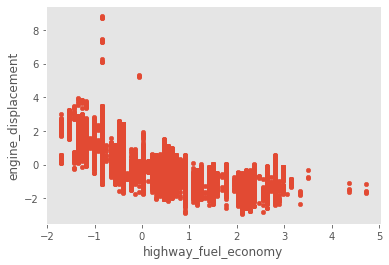

In [155]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

X_accident_train_undersample_rndf1 = pd.DataFrame(X_accident_train_undersample)
X_test_accident_rndf1 = pd.DataFrame(X_test_accident)

%matplotlib inline
X1 = X_accident_train_undersample_rndf1[[3,  2]].values
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('highway_fuel_economy'), plt.ylabel('engine_displacement')
plt.grid()
plt.show()
## We will take 5 clusters for labels
## Updating test data
Xt1 =X_test_accident_rndf1[[3,2]].values

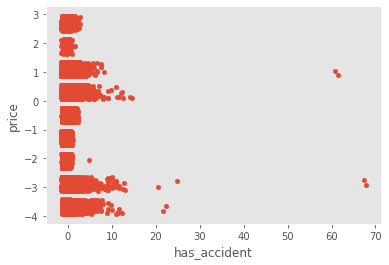

In [156]:
%matplotlib inline
X2 = X_accident_train_undersample_rndf1[[0,8]].values
plt.scatter(X2[:, 1], X2[:, 0]+np.random.random(X2[:, 1].shape)/2, 
             s=20)
plt.xlabel('has_accident'), plt.ylabel('price')
plt.grid()
plt.show()
## We will take 4 clusters for labels 
## Updating test data
Xt2 =X_test_accident_rndf1[[0,8]].values

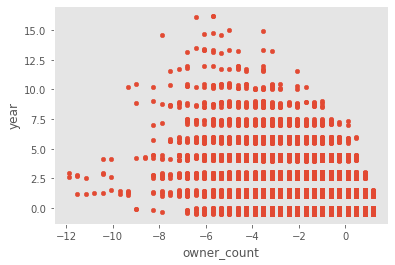

In [157]:
%matplotlib inline
X3 = X_accident_train_undersample_rndf1[[7, 10]].values
plt.scatter(X3[:, 1], X3[:, 0]+np.random.random(X3[:, 1].shape)/2, 
             s=20)
plt.xlabel('owner_count'), plt.ylabel('year')
plt.grid()
plt.show()
## We will take 10 clusters for labels 
## Updating test data
Xt3 =X_test_accident_rndf1[[7,10]].values

In [158]:
## Creating the final dataset
from sklearn.cluster import KMeans
cls1 = KMeans(n_clusters=5, init='k-means++',random_state=1)
cls1.fit(X1)
newfeature1 = cls1.labels_ # labels from first kmeans clustering

cls1.fit(Xt1)
newfeaturet1 = cls1.labels_ ## Updating test data

cls2 = KMeans(n_clusters=4, init='k-means++',random_state=1)
cls2.fit(X2)
newfeature2 = cls2.labels_ # labels from second kmeans clustering

cls2.fit(Xt2)
newfeaturet2 = cls2.labels_ ## Updating test data

cls3 = KMeans(n_clusters=10, init='k-means++',random_state=1)
cls3.fit(X3)
newfeature3 = cls3.labels_ # labels from second kmeans clustering

cls3.fit(Xt3)
newfeaturet3 = cls3.labels_ ## Updating test data

## new train data
Xremain = X_accident_train_undersample_rndf1[[1,4,5,6,9]]
X = np.column_stack((Xremain,pd.get_dummies(newfeature1),pd.get_dummies(newfeature2),pd.get_dummies(newfeature3)))

## new test data 
Xtremain = X_test_accident_rndf1[[1,4,5,6,9]]
Xt = np.column_stack((Xtremain,pd.get_dummies(newfeaturet1),pd.get_dummies(newfeaturet2),pd.get_dummies(newfeaturet3)))


In [159]:
## using Random forest classifer to model building
from sklearn.ensemble import RandomForestClassifier
randf_accident = RandomForestClassifier(n_estimators=100, random_state=1)
yhat_randf_accident = randf_accident.fit(X,y_accident_train_undersample).predict(Xt)
total_accuracy = accuracy_score(y_test_accident, yhat_randf_accident)
total_recall = recall_score(y_test_accident, yhat_randf_accident, average='weighted')
total_precision = precision_score(y_test_accident, yhat_randf_accident, average='weighted')
print('Accuracy :' ,total_accuracy)
print('Recall :' ,total_recall)
print('Precision :' ,total_precision) 

Accuracy : 0.8410328423224623
Recall : 0.8410328423224623
Precision : 0.7943552966944738


[Back: Task 2](#Task-2---'Has_Accidents'-Classification)

## -------------------- Modeling and Evaluation 4 --------------------
[Back to Top](#---------------------Introduction---------------------)

## Task 1 - 'Body_Type' Evaluations

### Model [1 - 'Body_Type'] and Evaluation - KNN

We ran two KNN models, one using "default" parameters (no parameters passed) and another model using hyperparameter tuned parameters via GridSearch. Since the default model uses an 'auto' algorithm we will assume that that the both the hypertuned and default models both were using the 'ball_tree' algorithm that models multidimensional space into "ball" like clusters where the estimated class falls within proximity of any of the nested balls centroids. The hypertuned model also suggested using p=1, utilizing the 'manhattan_distance' as opposed to the 'euclidean_distance' which makes sense since we were estimating with high dimensional data. Further discussion found [here](https://datascience.stackexchange.com/questions/20075/when-would-one-use-manhattan-distance-as-opposed-to-euclidean-distance) explains why the manhattan distance performs better in high-dimensional datasets which can be concluded that extreme differences using 'Euclidean distance' were punished due to the squaring term whereas 'manhattan' is less sensitive to outliers and given our known class imbalanced, thus leaned towards an algorithm that was better adjusted for it.

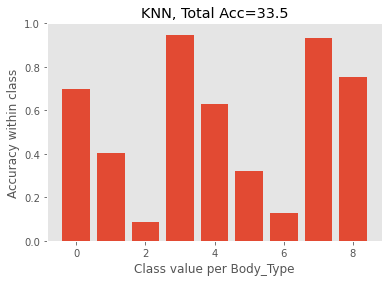

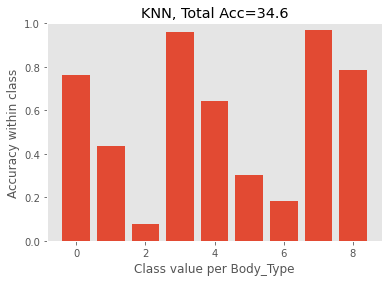

In [115]:
for i in [yhat_knn, yhat_knn_hyper]:
    def per_class_accuracy(ytrue,i):
        conf = mt.confusion_matrix(ytrue,i)
        norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
        return np.diag(norm_conf)

    def plot_class_acc(ytrue,i, title=''):
        acc_list = per_class_accuracy(ytrue,i)
        plt.bar(range(len(acc_list)), acc_list)
        plt.xlabel('Class value per Body_Type')
        plt.ylabel('Accuracy within class')
        plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,i)))
        plt.grid()
        plt.ylim([0,1])
        plt.show()

    
    plot_class_acc(y_test_body,i,title=("KNN"))

Assuming all other parameters are equal, applying 1 neighbors in the hypertuned model, resulted in a .2 increase in accuracy, .025 increase in recall and small (< .04) decreases in precision and the f1 score. In otherwords, the default and hypertuned model did not have any any significant differences compared to the default knn model. 

In [30]:
from varname import nameof
from sklearn.metrics import classification_report

for i in [yhat_knn, yhat_knn_hyper]:
    class_report_knn = classification_report(y_test_body, i)
    print('kNN Classification Report: ',)
    print(class_report_knn)
    print('='*80)

kNN Classification Report: 
              precision    recall  f1-score   support

           0       0.04      0.70      0.08       738
           1       0.09      0.40      0.15      1874
           2       0.07      0.08      0.07      1413
           3       0.19      0.94      0.31      2471
           4       0.65      0.63      0.64      7591
           5       0.90      0.32      0.48     34578
           6       0.59      0.13      0.21     19588
           7       0.99      0.93      0.96       133
           8       0.09      0.75      0.17      1402

    accuracy                           0.33     69788
   macro avg       0.40      0.54      0.34     69788
weighted avg       0.70      0.33      0.39     69788

kNN Classification Report: 
              precision    recall  f1-score   support

           0       0.06      0.76      0.11       738
           1       0.08      0.44      0.14      1874
           2       0.05      0.08      0.06      1413
           3       0.2

Looking into the ROC curve of our hypertuned model, we can see that we have an extremely high False Positive Rate indicating a large portion of our predictions were incorrectly classified as supported by our low accuracy rates. 

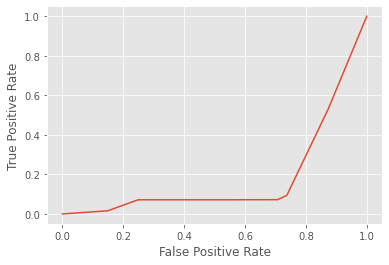

In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test_body,yhat_knn_hyper, pos_label=clf_knn_hyper.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

We can see that in our confusion_matrix heatmap below, in an ideal scenario, a bright yellow diagonal line would be present indicating the majority of our predictions as being correctly labeled. However, as shown in the ROC curve with a high False Positive Rate, we can see that in both models, there is a scattered prediction labels with high mis-classifications across almost all labels. Interestingly, our class variable of 5 (Body_Type='SUV/Crossover') had the highest true positives. Looking closer, if we were to follow the trend of high true postive labels, we can see that Classes {3,4,5,6,8} all had a majority of true positives which referring back to our undersampled plots of 'Body_Type' is the top 5 majority classes in terms of counts. This brings us back full circle in demonstrating how class imbalance effects the kNN model process as the centroids of the majority classes would hold much higher weight, essentially effecting how accurate the other classes would fall into using a n_neighbor of 1. 

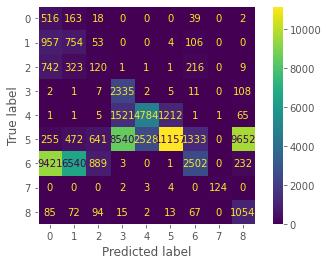

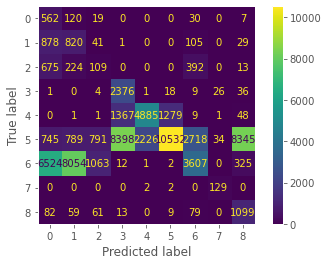

In [40]:
from sklearn.metrics import plot_confusion_matrix

for i in [clf_knn, clf_knn_hyper]:
    plot_confusion_matrix(i, X_test_body, y_test_body)
    plt.grid(False)

### Model [2 - 'Body_Type'] and Evaluation - Naive Bayes Model

For NB model built for “Body type”, we have selected Gaussian method since most of the features, besides “Has accidents”, which is a binary variable encoded with zero and 1, and normalized. So, we could treat this feature as continuous for our mode. However, the features in the data have a strong correlation as the choices of car buying are tightly related to many variables. That is reason we thought the outcomeof the model would not be desirable. 

However, its accuracy, recall and precision stand at 22.6%, 22.6% and 79.2% respectively, which exceeds the target the accuracy of 11.11%, given that we have “Body type” has 9 labels. NB can still be used if we do not find other model with a great accuracy, recall and precision.

In [146]:
from sklearn.metrics import confusion_matrix, classification_report
class_report = classification_report(y_test_body, yhat_NB)
print('Classification Report: ',)
print(class_report)

Classification Report: 
              precision    recall  f1-score   support

           0       0.04      0.79      0.08       738
           1       0.18      0.35      0.24      1874
           2       0.12      0.34      0.18      1413
           3       0.18      0.99      0.31      2471
           4       0.59      0.80      0.68      7591
           5       0.91      0.06      0.12     34578
           6       0.92      0.11      0.20     19588
           7       0.19      0.62      0.30       133
           8       0.06      0.78      0.11      1402

    accuracy                           0.23     69788
   macro avg       0.36      0.54      0.24     69788
weighted avg       0.79      0.23      0.21     69788



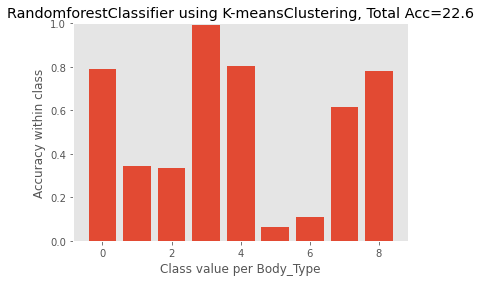

In [147]:
plot_class_acc(y_test_body,yhat_NB,title="RandomforestClassifier using K-meansClustering")

### Model [3 - 'Body_Type'] and Evaluation - Random Forest Classifer with K-means Clustering

This model has generated highest accuracy (41.6%) out of all models that we have built. In addition, the recall (41.6%) and the precision (60.7%) are pretty high. Here we are exceeding 11.11% target level by a huge margin. However, some other models such as NB has generated more precision than this model, but in case of “Body type”, we do not want to discriminate one decision over other as every decision are short of equally important when it comes to knowing body type. Thereby, we lean on this model as our model of choice.

In [160]:
from sklearn.metrics import confusion_matrix, classification_report
class_report = classification_report(y_test_body, yhat_randf)
print('Classification Report: ',)
print(class_report)

Classification Report: 
              precision    recall  f1-score   support

           0       0.18      0.63      0.27       738
           1       0.13      0.33      0.19      1874
           2       0.07      0.41      0.12      1413
           3       0.19      0.63      0.30      2471
           4       0.38      0.80      0.51      7591
           5       0.91      0.29      0.44     34578
           6       0.61      0.43      0.50     19588
           7       0.57      0.59      0.58       133
           8       0.07      0.24      0.11      1402

    accuracy                           0.41     69788
   macro avg       0.35      0.48      0.34     69788
weighted avg       0.68      0.41      0.44     69788



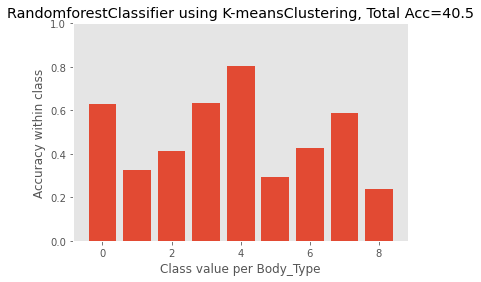

In [161]:
plot_class_acc(y_test_body,yhat_randf,title="RandomforestClassifier using K-meansClustering")

### Model [5 - 'Body_Type'] and Evaluation - Random Forest

We are picking random forest as one of our models because random forest prevents overfitting by creating trees on random subsets and thus a very good model to use in the analysis. In general, the more trees the better the results. However, we had to limit the number of trees that were created due to limit of our computer processing power. Random forest requires too much computational power to build all the trees and getits output.

In [284]:
from sklearn.metrics import confusion_matrix
cm_randomforrest = confusion_matrix(y_test_body, yhat_body_randomforrest)

Text(60.0, 0.5, 'Truth')

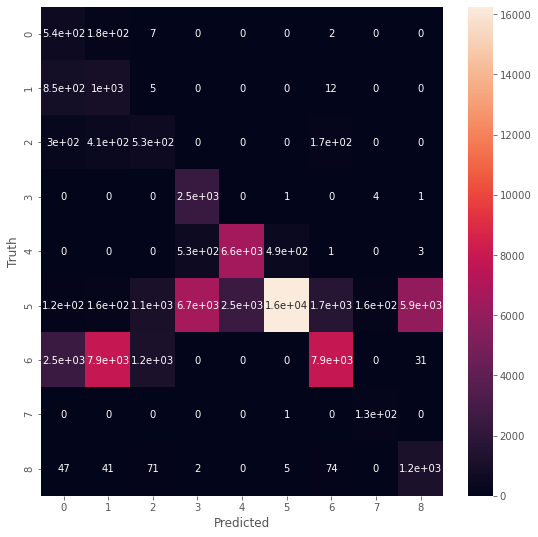

In [285]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(9,9))
sn.heatmap(cm_randomforrest, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

From the matrix above, we have "Truth" data on the Y-axis, and "Predicted" data on the X-axis. What this means is that we have zero 50 times, and 50 times it predicted them to be zero. For zero, it generally performs very well. For “5”, from position (6,1) of the above matrix, it means that we have that the truth of 6 occurred 5 times but it was predicted to be 1 that occurred 5 time.

## Task 2 - 'Has_Accidents' Evaluations

### Model [1 - 'Has_Accident'] and Evaluation - Random Forest

Ranodm forest builds multiple decision tree and merges them together to achieve better accuracy. That’ s the reason why we are using it here. Now, let check the difference of the actual and predicted values generated from Random Forest. Here, we got an accuracy of 38.9% by using random forest when analyzing the “Has_accident” attribute. Again the accuracy isn’t that good, but it helps us to gain different perspectives so we can compare performance with different model. In the next section, you will see that we use random with knn to gain better accuracy.

In [295]:
accident_randomforest_report = classification_report(y_test_accident, yhat_accident_randomforest)
print('Random Forest Classification Report: ',)
print(accident_randomforest_report)
print('='*80)

Random Forest Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.36      0.51     61318
           1       0.11      0.59      0.19      8470

    accuracy                           0.39     69788
   macro avg       0.49      0.47      0.35     69788
weighted avg       0.77      0.39      0.47     69788



In [292]:
from sklearn.metrics import confusion_matrix
cm_accident_randomforrest = confusion_matrix(y_test_accident, yhat_accident_randomforest)

Text(60.0, 0.5, 'Truth')

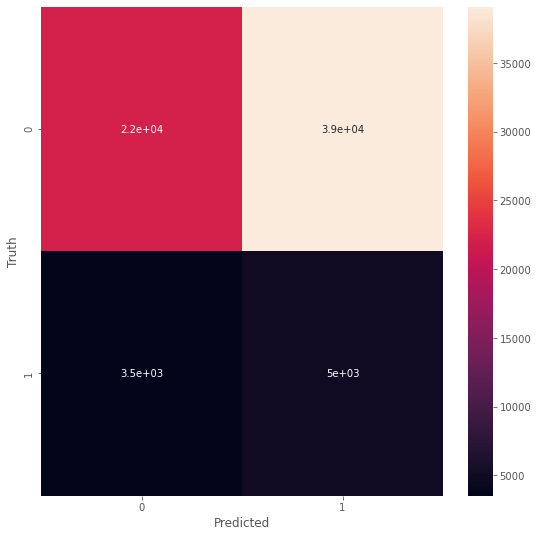

In [293]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(9,9))
sn.heatmap(cm_accident_randomforrest, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Model [2 - 'Has_Accident'] and Evaluation - KNN

“Has_accident” data is highly imbalanced as it represents 88% true vs 12% false. After train with the balanced (undersampled) dataset, test with the imbalanced dataset, we ran two KNN models, one was using a parameterization of setting n_neighbors in range of 1~11, 'weights'='uniform' and metric using the 'euclidean' distance and the another model was using the same parameters with the kd_tree algorithm. It returned the best accuracy of 0.45620 with default parameters, an accuracy of 0.42016 with kd_tree algorithm.

Looking the below classification report, we see precision [Precision(p) = TP/(TP+FP)]is 0.86 for no_accident cars, 0.11 for has_accident cars, which means the higher the precision is, the lower the number of false positive errors occurred. The recall [Recall(r) = (TP/TP+FN)]is 0.41 for no_accident cars, 0.51 for has_accident cars, which means the large recall has very few positive observations misclassified as the negative class. The f1-score [F1 = 2rp/(r+p)]is 0.55 for no_accident cars, 0.18 for has_accident cars, which means very few cars has_accidents.

In [308]:
from sklearn.metrics import confusion_matrix, classification_report

class_report_accident_knn = classification_report(y_test_accident, yhat_accident_knn)
print('Classification Report: ',)
print(class_report_accident_knn)

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.41      0.55     61318
           1       0.11      0.51      0.18      8470

    accuracy                           0.42     69788
   macro avg       0.48      0.46      0.36     69788
weighted avg       0.77      0.42      0.51     69788



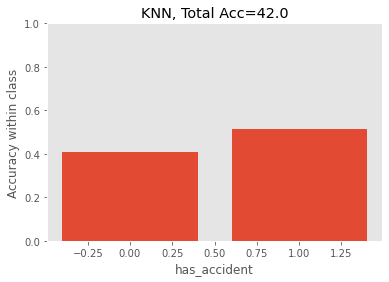

In [309]:
def per_class_accuracy(ytrue,yhat_accident_knn):
    conf = mt.confusion_matrix(y_test_accident,yhat_accident_knn)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat_accident_undersample, title=''):
    acc_list = per_class_accuracy(y_test_accident,yhat_accident_knn)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('has_accident')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat_accident_knn)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
plot_class_acc(y_test_accident,yhat,title="KNN")

Below we use the fpr and tpr as false positive rate and true positive rates in an ROC curve for a given classifier. Looking into the ROC curve of our knn model, we can see that we have a slightly high False Positive Rate which indicates a large portion of our predictions are incorrectly classified.


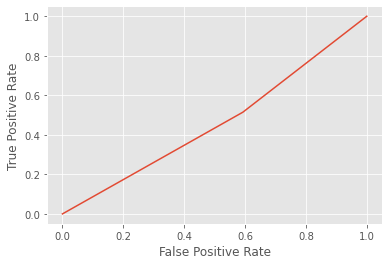

In [310]:
fpr, tpr, _ = roc_curve(y_test_accident,yhat_accident_knn, pos_label=clf_accident_knn.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

From the matrix below, we have "Truth" data on the Y-axis, and "Predicted" data on the X-axis. 0.42 of accuracy to predict the true no_accident rate,0.51 of accuracy to predict the true has_accident rate.

Text(60.0, 0.5, 'Truth')

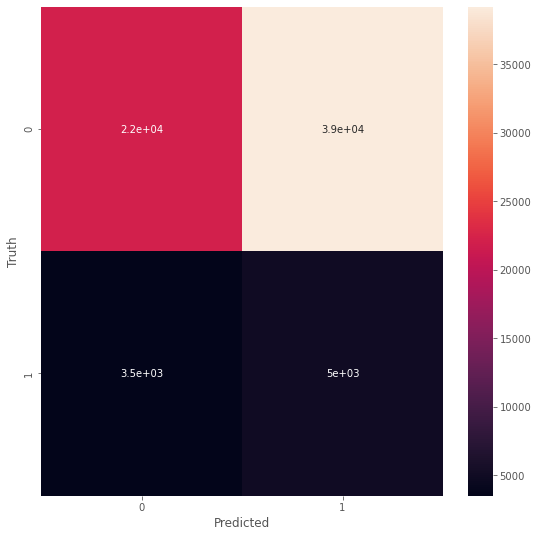

In [171]:
from sklearn.metrics import confusion_matrix
cm_accident_randomforrest = confusion_matrix(y_test_accident, yhat_accident_randomforest)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(9,9))
sn.heatmap(cm_accident_randomforrest, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


### Model [3 - 'Has_Accident'] and Evaluation - Naive Bayes 

Like that of  “Body Type”, NB model for “Has Accident” is built with Gaussian method because most of the explanatory variables are contineous besides the categorical variables of “Body Type”. However, we have encoded the “Body Type” with numerical values and normalized it so that it behave as a contineous variable. As noted earlier, many features of the dataset are not independent and show  strong correlation. In addition, the dataset for “Has Accident” is highly imbalanced and some features may not have normal distribution. Because of that, the performance of the model is not good as its accuracy, recall and precision stand at 32.3%, 32.3% and 76.9% respectively, compared to the target accuracy of 50% (binary response). Please note that the model is performing better when it comes toprecision, which should be the sought after statistics for “Has Accident” model. However, we will pursue other models to find our best fit. 

In [127]:
from sklearn.metrics import confusion_matrix, classification_report
class_report_nb_accident = classification_report(y_test_accident, yhat_NB_accident_knn)
print('Classification Report: ',)
print(class_report_nb_accident)

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.27      0.42     61318
           1       0.11      0.68      0.20      8470

    accuracy                           0.32     69788
   macro avg       0.49      0.48      0.31     69788
weighted avg       0.77      0.32      0.39     69788



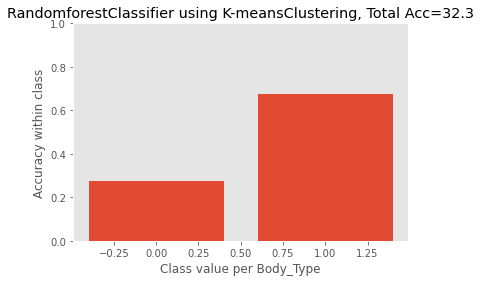

In [129]:
plot_class_acc(y_test_accident,yhat_NB_accident_knn,title="RandomforestClassifier using K-meansClustering")

### Model [4 - 'Has_Accident'] and Evaluation - Random Forest Classifer with K-means Clustering 

Before plunging into the result discussion, we would like to explain the dataset of “Has Accident” because it is really imbalanced dataset as it represents 88% true vs 12% false. Even though we have under-sampled the dataset for training purpose, we are cautious about optimizing the model because the slight of overfitting will provide us with an undesirable outcome. Therefore, this model plays an important role in developing the model with an optimum bias so that it does not fail while generating the variance. It works as expected as its accuracy, recall and precision stand at 81%, 81% and 78.8% respectively, which beats 50%  the target accuracy (binary labels).  As explained earlier, we care about precision for the model as we do want our client to decide wrongly knowing the used car does not have any accident while in fact it has. This model has risen to the top because of its performance exceeds others.


In [130]:
from sklearn.metrics import confusion_matrix, classification_report
class_report = classification_report(y_test_accident , yhat_randf)
print('Classification Report: ',)
print(class_report)

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     61318
           1       0.17      0.08      0.10      8470

    accuracy                           0.84     69788
   macro avg       0.52      0.51      0.51     69788
weighted avg       0.79      0.84      0.81     69788



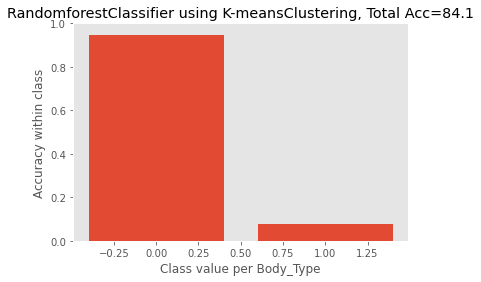

In [131]:
plot_class_acc(y_test_accident,yhat_randf,title="RandomforestClassifier using K-meansClustering")

## -------------------- Modeling and Evaluation 5 --------------------
[Back to Top](#---------------------Introduction---------------------)

#### Model Performance Summary:
<u>**Task 1: 'BODY_TYPE'**</u>
- **KNN (default)**: 0.33453
- **KNN (hypertuned)**: 0.34560
- **ADABoostClassifier (default)**: 0.2262
- **ADABoostClassifier (hypertuned)**: 0.55520
- **Naive Bayes**: 0.22631397948071302
- **Random Forest Classifer with K-means Clustering**: 0.405284576144896
- **Random Forest**: 0.5024216197627099

<u>**Task 2: 'HAS_ACCIDENTS'**</u>
- **Random Forest**: 0.3881326302516192
- **Logistic Regression**: 0.28469077778414625
- **KNN Model ('euclidean')**: 0.45620
- **KNN Model ('kd_tree')**: 0.42016
- **Naive Bayes**: 0.3230784662119562
- **Random Forest Classifer with K-means Clustering**:0.8410328423224623

### Model Evaluation: 
1. <u>**KNN**</u>:
- **Advantages:** 
    - k-nearest neighbor classifier is a lazy learning algorithm, easy to implement. 
    - The main advantage of such a memory-based approach is that the classifier immediately adapts as we collet new training data – Reference from Sebastian Raschka’s Python Machine Learning book p94.
- **Disadvantages:** 
    - It doesn’t learn a discriminative function from the training data, it only memorizes the training dataset instead. 
    - It doesn’t perform well on the imbalanced data, the large data or the dataset with high dimensions.
    - It’s sensitive to outliers and missing values.

2. <u>**Random Forest classifier**</u>:
- **Advantages:** 
    - It helps to reduce overfitting in decision tree and improve the accuracy
    - Random Forest could be used on regression or classification task. 
    - High variance and low bias for each decision tree and handle unbalanced data
- **Disadvantages:** 
    - It could be slow on computer as it requires much computation power to build all the tress to get their output.
    - Not all random forest models are interpretable.
- **Performance:**
    - Performance: We get an accuracy  of 0.524% for the “body_part” attribute, and an accuracy of 0.389% for the “with accident” attribute.

3. <u>**Logistic Regression**</u>:
- **Advantages:** 
There is less transformation needed in order to make the model return in a reasonable amount of time. Scaler transformation will increase the accuracy, but is not required for performance as the model performs well at scale regardless of whether the data is normalized or not.
- **Disadvantages:** It’s more difficult to interpretate the model, because the weights is multiplicative and not additive
- **Performance:**  Accuracy is  0.284, There are many different settings that allow the model to have the best possible accuracy. These methods can be iterated with a grid search method.


4. <u>**Naive Bayes**</u>:
- **Advantages:** 
    - This classification is robust to isolated noise because such points are averaged out when estimating conditional probabilities from data.
    - It can also handle missing values by ignoring the example during model building and classification. 
    - It is robust to irrelevant attributes as an irrelevant attribute is uniformly distributed and the conditional probability has no impact on the overall computation
- **Disadvantages:** 
    - Correlated attributes can degrade the performance of the model because the conditional independence assumption is violated. 
    - If there is zero-frequency in the dataset, the conditional probability related to that frequency will be zero, the scenario which will cause error in the prediction. However, this problem can be overcome by using smoothing function such as Laplace smoothing.



5. <u>**Random Forest with K-Means**</u>:
- **Advantages:** 
    - We know RF is a strong classifier which optimizes the process via slow learning process, and the more the uneven feature space it has to travel, the more the slowly it will learn. And it may not achieve the global minima with the number of iterations we would like to employ, thereby not giving us with optimum result. Here comes the kmeans which clusters the feature space and generates the label that we deem appropriate. So, when the process optimizes the convex funciton, it does not need to travel to farthest feature spaces without gaining much information about the target variables. 
    - Since the clustering is smoothening the feature space, it prevents the RF to overfit the model, resulting a lesser varience.
- **Disadvantages:**
    - The clustering process smoothen the feature space and the same time, it prevents the process to the gain the fullest information, thereby leaving any important information needed for the model.
    
6. <u>**ADABoost**</u>:
- **Advantages:** 
    - The ADABoost model places an emphasis on error terms in that it iteratively places a heigher weight on mis-classified values. In our model using hypertuned parameters, balancing both the 'n_estimators' and 'learning_rate' of the model, we managed to get a comparatively, robust model. A future area of analysis would be to further do a deep dive on the weak learning ability of ADABoost by looking into what specifc 'weak leaner' contributed to the model errors. 
- **Disadvantages:** 
    - One of the main disadvantages of the model is that the model is still sensitive to noise and outliers. 
- **Performance:**
    - Performance: The default model resulted in a accuracy of 0.2262 while the hypertuned model resulted in 0.55520. 

### Model Comparison

#### Task 1 - 5x2cv paried t-test
Using the top 2 performing models based on model accuracies for our first task, we will next run a 5x2cv paried t-test to compare the performance between the top 2 models. With a p-value of (0.557), we fail to reject the null hypothesis that there is significant difference and thus we have evidence to suggest that there is no statisical difference between the performance of the two models. 

 <u>Top 2 'Body_Type' classification Model</u> :
1. Random Forest Classifer with K-means Clustering: 0.405284576144896
2. Random Forest: 0.5024216197627099

In [163]:
%%time
#!pip install mlxtend
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=randf,
                          estimator2=clf_randomforrest,  
                          X=X_body_train_undersample, y=y_body_train_undersample,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.629
p value: 0.557
Wall time: 5.26 s


#### Task 2 - 5x2cv paried t-test
Using the top 2 performing models based on model accuracies for our second task, we will next run a 5x2cv paried t-test to compare the performance between the top 2 models. With a p-value of (p < 0), we reject the null hypothesis and thus we have evidence to suggest that there statisical difference between the performance of the two models. 

 <u>Top 2 'Has_Accidents' classification Model</u> :
1. Random Forest Classifer with K-means Clustering:0.8410328423224623
2. KNN Model ('kd_tree'): 0.42016

In [170]:
%%time
t2, p2 = paired_ttest_5x2cv(estimator1=randf_accident,
                            estimator2=clf_accident_knn2,  
                            X=X_accident_train_undersample, y=y_accident_train_undersample,
                            random_seed=1)

print('t statistic: %.3f' % t2)
print('p value: %.3f' % p2)

t statistic: -18.740
p value: 0.000
Wall time: 5min 37s


## -------------------- Modeling and Evaluation 6 --------------------
[Back to Top](#---------------------Introduction---------------------)

In this next section, we will evaluate the feature importance of our attributes in both our Tasks. To drive this analysis, we will use our Random Forest model as the classifier  model.

### Task 1 (Body_Type) - Feature Importance

The type 5 features of 'Body_Type' is the following:
1. Horsepower
2. City_Fuel_Economy
3. Price
4. Engine_Displacement
5. Highway_Fuel_Economy

We can see that based on our feature importance visualization (below), horsepower holds a disporportionally high weight in regards to modeling out 'Body_Type', in fact it is the most discrimiative feature in the dataset. This could be explained that most cars with a high horsepower usually have similar features in terms of price, dimensions, and design. For example, it's very rare for a Minivan or Pickup Truck to be classified as a "sports car". Additionally, we are not surprised to see that 'City_Fuel_Economy' is the next attribute that has significant weight albeit much lower than the 'Horsepower' attribute. We can roughly equate that 'City_Fuel_Economy' has somewhat of a effect on the 'Body_Type' but not enough for it to dominate the model. Since almost everything outside of 'Horsepower' holds substantially lower weight (x < 0.2), it is difficult to distinguish those features in regards to the 'Body_Type'. 

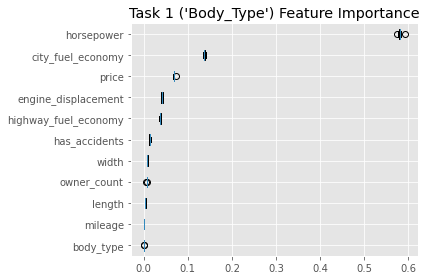

In [76]:
from sklearn.inspection import permutation_importance

task1_feature_importance = clf_randomforrest.feature_importances_
task_1_result = permutation_importance(clf_randomforrest, X_body_train_undersample,y_body_train_undersample, n_repeats=10,
                                random_state=42, n_jobs=-1)
task_1_sorted_idx = task_1_result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(task_1_result.importances[task_1_sorted_idx].T,vert=False,labels=df_pca.columns[task_1_sorted_idx])
ax.set_title("Task 1 ('Body_Type') Feature Importance")
fig.tight_layout()
plt.show()

### Task 2 (Has_Accidents) - Feature Importance

The type 5 features of 'Has_Accidents' is the following:
1. Owner_Count
2. Length
3. Has_Accidents
4. City_Fuel_Economy
5. Price

Permutation methods shuffles the features to find which feature is causing the more error when it is left out. In other way, if we drop a feature which is not important, the model will not produce much error, and on the other hand, dropping important feature will yield more error. Therefore, by doing the permutation of features, the process can let us know which one is important.
In random forest estimator, we are selecting features by grabbing numbers of features in each run. The permutation feature importance is defined to decrease in a model score when a single feature value is randomly shuffled, and it is important. The importance values of the top features represent larger factions.
In our “Body Type” model, the horsepower score is 0.58, meaning this model has produced a significant amount of error when this feature is dropped. And from the business standpoint, the car types with higher horsepower are generally meant for bigger car than those of lower horsepower. So, it does not come as a surprise when this feature is selected as a top important feature.
Similarly, in case of “Has Accident” model, we can see that the owner_counts feature has become a top feature. It makes sense because when the car changes hand, it is prone to have higher accidents. So, the higher owner_counts, the higher chance of the car being involved in the accident.

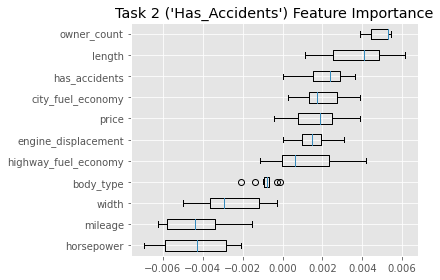

In [77]:
task2_feature_importance = clf_randomforest_accident.feature_importances_

task_2_result = permutation_importance(clf_randomforest_accident, X_body_train_undersample,y_body_train_undersample, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = task_2_result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(task_2_result.importances[sorted_idx].T,vert=False,labels=df_pca.columns[sorted_idx])
ax.set_title("Task 2 ('Has_Accidents') Feature Importance")
fig.tight_layout()
plt.show()

## -------------------- Deployment --------------------
[Back to Top](#---------------------Introduction---------------------)

#### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?
We believe that our model would be useful for the used-car industry as well as any and all buyers that are looking to buy used car. Purchasing a used car could be a stressful process, especially for the first-time buyer. Buyers often want to get the best deal that their money can get.The model we build could help to provide better insights and perspectives for all of the buyers to help them to understand what are the important attributes they should care about and pay attention to. 

The model also helps the buyers to understand the factors/features of a car that increase the car’s value. Furthermore, the dataset also helps user to understand what are the best cars for resale   

The used car industry could also benefit from our models as it helps them to understand what kind of used cars are more likely to sell as well as to make better used car purchases for their inventory, and offer better used cars for their customers. Knowing what are the most popular used cars in the market, could improve the used car company’s inventory to make maximum customer profit and also increase their customer base.Additionally, understanding the facts and data the model presents could also ensurethe buyers’ purchase holds its value in the future, and helps them to protect the value of their property.

#### How would you measure the model's value if it was used by these parties?
One way we could measure the model’s value if it was used by the used-car industry would be in the measurement of used car sales and the used car company’s profit. Our model helps the company to make better purchases on used car inventory that’s more popular/more desirable by the customers.

If the used car company changes their inventory purchasing strategy. An Increase insales and profit would be a clear indication that the used-car industry has been making better decisions.  

Another way we could measure the value would be in terms of customer satisfactionfor those who made used car purchase based on our model. In this case, higher customer satisfaction for those whom have made used car purchases based on our data would show that used car buyers are happy with our model and think the data is useful.

#### How would your deploy your model for interested parties? 
We would like to share our knowledge and data as free and open source so that anyone that thinks they are useful can benefit from them. GitHub is a great way for 
us to share our findings to the data science community. Furthermore, we would alsolike to share this data as a webpage so anyone that’s interested in learning could have access to it.

Another way we would like to deploy the work is with local used car dealerships to see if they are interested and, if so, we can have partnerships with them to iterate and improve our findings further.

#### What other data should be collected?
Other information that we would love to gain more perspective regarding would be used car customer data. We would like to understand more why buyers are making purchases for particular types of cars. In addition, we would love to understand if they regret their purchase of a used car after they made the purchase. Having this additional data collected could give us a even better, more holistic picture and may better explain the interpretation of the data. In addition, we would also want to try and understand the demographic of the buyers who made purchases for used cars to see if age, gender, and marital status influence the decision of the buyer when they are making used car purchases.

#### How often would the model need to be updated, etc.? 
While we initially got the data from Kaggle, we would like the model to be updated on weekly basis. In the future, we would like to import and run the model in the cloud where more computing power is available. This would help us to achieve better accuracy and update the model in a more efficient way.

## -------------------- Exceptional Work --------------------
[Back to Top](#---------------------Introduction---------------------)

In our model building, there are a few sections that we believe deserve exception brownie points:
1. In the Modeling and Evaluation 3 section, for a couple of our models we used GridSearch hyperparameter tuning to optimize our model. 
2. We modeled 5 models for each of our 2 tasks totalling 10 models total. A few of these models which included Clustering.
3. One area we spent a good portion of our time was on "preparing" the data through Undersampling techniques that attempts to solve one of our major class imbalance issues.